# 4. Logistic Model
The models I create will be attempting to evaluate the gunners in two separate categories: before the catch and after the catch. To evaluate the gunners before the catch, I will be looking at the variables *timeToBeatVise*, *disFromReturner*, *disFromLOS*, *release*, *correctRelease*, *topSpeed*, and *speedDev*. Using these variables, the model will attempt to predict the probability of each gunner causing a fair catch.

## 4.1 Imports

In [1]:
library(tidyverse)
library(caret)
library(lmtest)
library(MASS)
library(here)

source(here("R", "00_source.R"))

specialistData <- read.csv(here("data", "specialist_data.csv"), 
                           na.strings = c('NA', NA, '', ' '))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift


Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


here() starts at C:/Users/Hunter



## 4.2 Change Variables to Factors

In [2]:
specialistData$fairCatch <- ifelse(specialistData$specialTeamsResult == 'Fair Catch', 1, 0)

specialistData$correctRelease <- as.factor(specialistData$correctRelease)
specialistData$release <- as.factor(specialistData$release)

## 4.3 Subset Data to Only Include First Man Down
There are two gunners in each play, but only one result. One gunner might perform poorly during a play, but the play still ends in a fair catch due to the other gunner's effort. To avoid this, I will only train the model on the gunners that were the first man down.

In [3]:
FMDData <- specialistData %>% filter(firstManDown == 1)

# remove NAs
FMDData <- FMDData[complete.cases(FMDData[c('timeToBeatVise', 'returnYds')]), ]

## 4.4 Create Models
The variables in the model were selected using forward stepwise selection with AIC as the criterion. This helps pick out the variables with the most predictive power. These ended up being *timeToBeatVise*, *disFromReturner*, *disFromLOS*, and *topSpeed*

In [4]:
# create full model
FMDLogitFull <- glm(fairCatch ~ timeToBeatVise + disFromReturner + disFromLOS + release + correctRelease + topSpeed + speedDev, 
                    data = FMDData, 
                    family = 'binomial')

# null model
FMDLogitNull <- glm(fairCatch ~ 1, data = FMDData, family = 'binomial')

# select vars with forward stepwise selection (AIC)
stepAIC(FMDLogitNull, scope = list(lower = FMDLogitNull, upper = FMDLogitFull), 
        k = 2, direction = "forward")

fSelectedLogitAIC <- glm(fairCatch ~ timeToBeatVise + disFromReturner + disFromLOS + topSpeed, 
                    family = "binomial", 
                    data = FMDData)

Start:  AIC=2858.11
fairCatch ~ 1

                  Df Deviance    AIC
+ timeToBeatVise   1   2421.6 2425.6
+ disFromReturner  1   2463.4 2467.4
+ release          1   2830.5 2834.5
+ disFromLOS       1   2838.5 2842.5
+ correctRelease   1   2847.3 2851.3
+ topSpeed         1   2847.5 2851.5
+ speedDev         1   2848.7 2852.7
<none>                 2856.1 2858.1

Step:  AIC=2425.58
fairCatch ~ timeToBeatVise

                  Df Deviance    AIC
+ disFromReturner  1   2212.1 2218.1
+ disFromLOS       1   2390.1 2396.1
+ topSpeed         1   2408.7 2414.7
+ speedDev         1   2417.9 2423.9
<none>                 2421.6 2425.6
+ release          1   2420.7 2426.7
+ correctRelease   1   2421.1 2427.1

Step:  AIC=2218.14
fairCatch ~ timeToBeatVise + disFromReturner

                 Df Deviance    AIC
+ disFromLOS      1   2090.8 2098.8
+ topSpeed        1   2157.4 2165.4
+ speedDev        1   2195.9 2203.9
+ release         1   2208.6 2216.6
<none>                2212.1 2218.1
+ corr


Call:  glm(formula = fairCatch ~ timeToBeatVise + disFromReturner + 
    disFromLOS + topSpeed, family = "binomial", data = FMDData)

Coefficients:
    (Intercept)   timeToBeatVise  disFromReturner       disFromLOS  
        9.76882         -0.45296         -0.16662         -0.08949  
       topSpeed  
       -0.21651  

Degrees of Freedom: 2101 Total (i.e. Null);  2097 Residual
Null Deviance:	    2856 
Residual Deviance: 2087 	AIC: 2097

When using BIC as the criterion, which is more conservative, the *topSpeed* variable is dropped.

stepAIC(FMDLogitNull, scope = list(lower = FMDLogitNull, upper = FMDLogitFull), 
        k = log(nrow(FMDData)), direction = "forward")

In [5]:
fSelectedLogitBIC <- glm(fairCatch ~ timeToBeatVise + disFromReturner + disFromLOS, 
                         family = "binomial", 
                         data = FMDData)

## 4.5 Compare Models

### 4.5.1 Model Summaries
The model selected with AIC has lower deviance values and a lower AIC. Therefore it is a better model.

In [6]:
summary(fSelectedLogitAIC)


Call:
glm(formula = fairCatch ~ timeToBeatVise + disFromReturner + 
    disFromLOS + topSpeed, family = "binomial", data = FMDData)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.9045  -0.7645   0.4366   0.7836   2.5075  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)      9.76882    1.00781   9.693  < 2e-16 ***
timeToBeatVise  -0.45296    0.03313 -13.674  < 2e-16 ***
disFromReturner -0.16662    0.01072 -15.538  < 2e-16 ***
disFromLOS      -0.08949    0.01104  -8.109  5.1e-16 ***
topSpeed        -0.21651    0.10805  -2.004   0.0451 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2856.1  on 2101  degrees of freedom
Residual deviance: 2086.8  on 2097  degrees of freedom
AIC: 2096.8

Number of Fisher Scoring iterations: 5


In [7]:
summary(fSelectedLogitBIC)


Call:
glm(formula = fairCatch ~ timeToBeatVise + disFromReturner + 
    disFromLOS, family = "binomial", data = FMDData)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.9385  -0.7702   0.4369   0.7836   2.5794  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      8.016199   0.481439   16.65   <2e-16 ***
timeToBeatVise  -0.433127   0.031153  -13.90   <2e-16 ***
disFromReturner -0.164789   0.010658  -15.46   <2e-16 ***
disFromLOS      -0.100603   0.009634  -10.44   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2856.1  on 2101  degrees of freedom
Residual deviance: 2090.8  on 2098  degrees of freedom
AIC: 2098.8

Number of Fisher Scoring iterations: 5


### 4.5.2 Likelihood Ratio Test
Because the two models are hierarchical, a Likelihood Ratio Test can be used to compare the models. The test shows that the p-value is 0.0444. This means the null hypothesis can be rejected at a .05 significance level, suggesting that the complex model (AIC) provides a better fit to the data.

In [8]:
lrtest(fSelectedLogitBIC, fSelectedLogitAIC)

,#Df,LogLik,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4,-1045.405,NA,NA,NA
2,5,-1043.385,1,4.041304,0.04439949


## 4.6 Evaluate Model
The model's accuracy can be estimated by splitting the data into a testing and training set. The model is trained on the training set. Once the model is developed, it attempts to classify each observation in the testing set as either a fair catch or not a fair catch. This can then be compared to the actual classification of each observation to estimate the model's accuracy. This is repeated using k-fold cross validation to test the model on several different testing and training sets. This allows for a more accurate estimation.

The final estimated accuracy of the model is about 75.17%.

In [9]:
set.seed(60)

k <- 10
kFoldAccuracy <- numeric(k)
CVFolds <- createFolds(FMDData$fairCatch, k=k, returnTrain = T)

concatConfMatrix <- matrix(0, nrow = 2, ncol = 2)

for (i in 1:k) {
  folds <- CVFolds[[i]]
  train <- FMDData[folds, ]
  valid <- FMDData[-folds, ]
  
fSelectedLogitAIC <- glm(fairCatch ~ timeToBeatVise + disFromReturner + disFromLOS + topSpeed, 
                    family = "binomial", 
                    data = train)
  
  fitted.results <- predict(fSelectedLogitAIC,newdata = valid,type = 'response')
  fitted.results <- ifelse(fitted.results > 0.5,1,0)
  misClasificError <- mean(fitted.results != valid$fairCatch)
  
  kFoldAccuracy[i] <- 1 - misClasificError
  
  confMatrix <- confusionMatrix(as.factor(fitted.results), as.factor(valid$fairCatch))
  
  concatConfMatrix <- confMatrix$table + concatConfMatrix
}

mean(kFoldAccuracy)

[1] 0.7516768

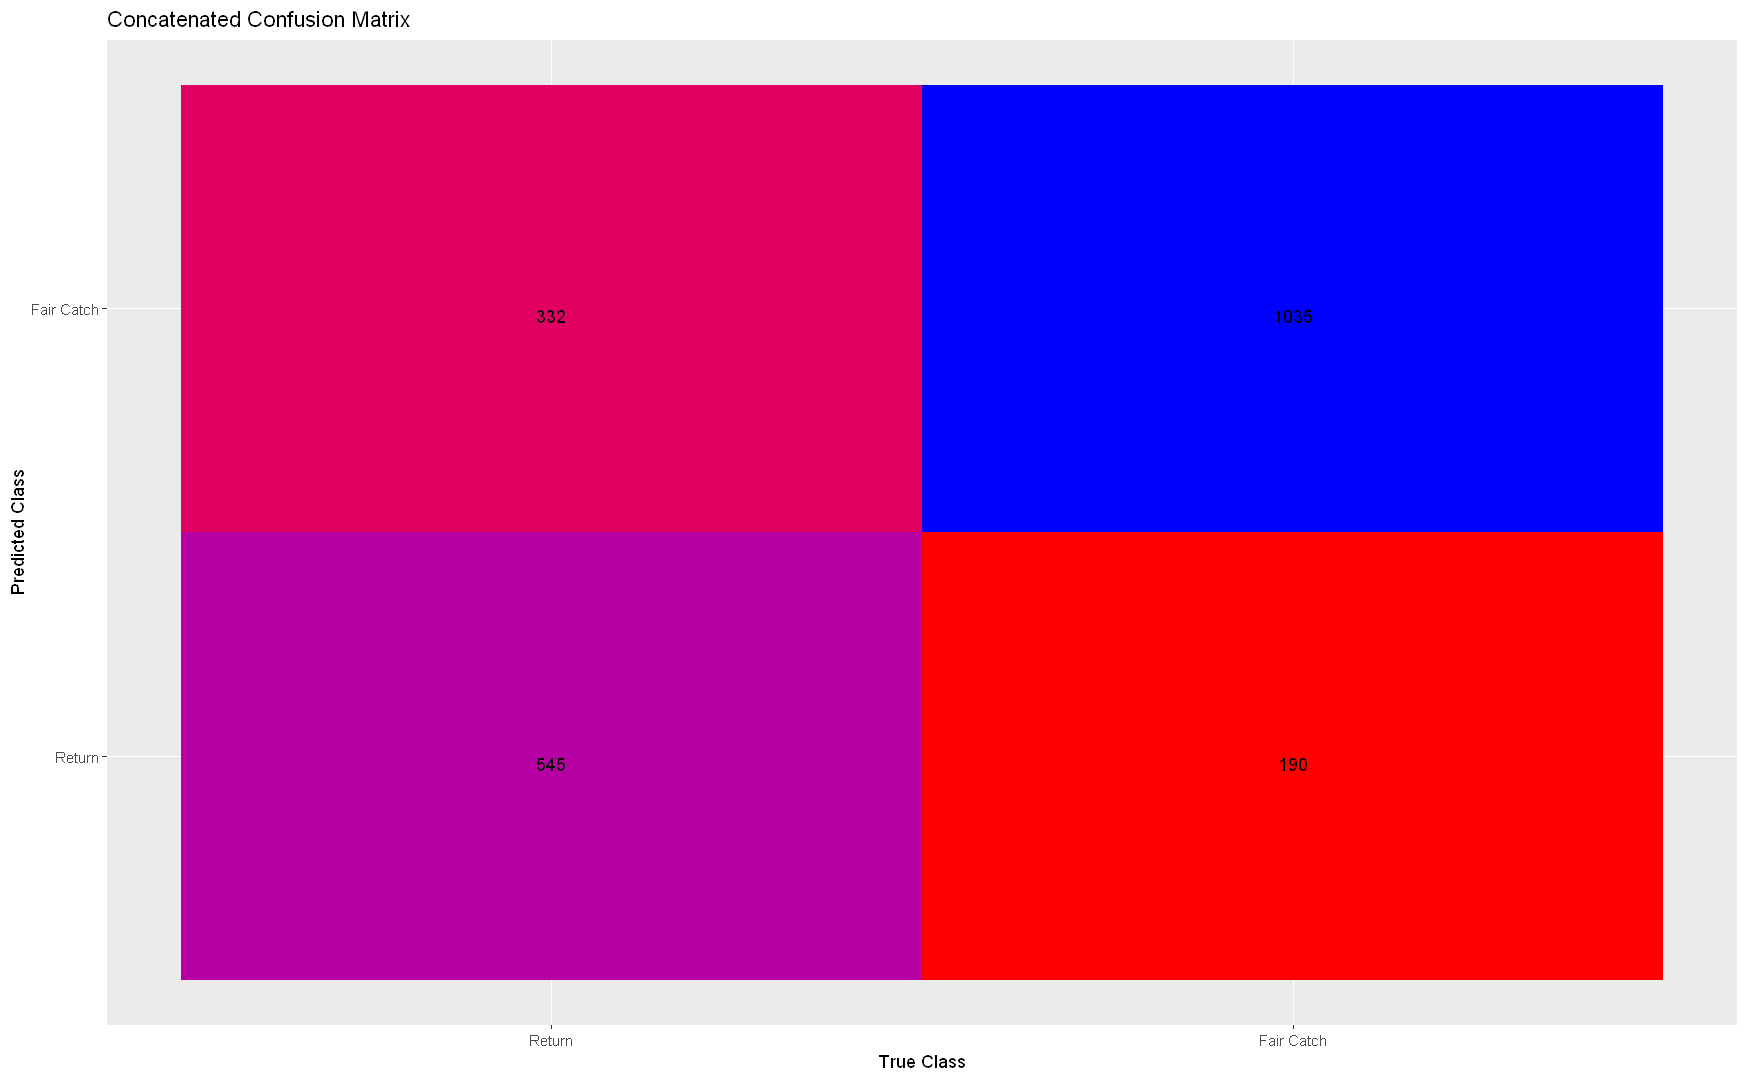

In [10]:
confusionDF <- data.frame(trueClass = factor(c(0, 0, 1, 1)),
                 predictedClass = factor(c(0, 1, 0, 1)),
                 Y = c(concatConfMatrix[1, 1], concatConfMatrix[2, 1], concatConfMatrix[1, 2], concatConfMatrix[2, 2]))

# adjust plot size
options(repr.plot.width=14.5623, repr.plot.height=9)

ggplot(confusionDF, aes(x = trueClass, y = predictedClass)) +
  geom_tile(aes(fill = Y)) +
  geom_text(aes(label = sprintf("%1.0f", Y)), vjust = 1) +
  scale_fill_gradient(low = "red",
                      high = "blue",
                      trans = "log") +
  scale_x_discrete(labels = c("0" = "Return", "1" = "Fair Catch")) +
  scale_y_discrete(labels = c("0" = "Return", "1" = "Fair Catch")) +
  theme(legend.position = "none") + 
  xlab("True Class") +
  ylab("Predicted Class") +
  ggtitle("Concatenated Confusion Matrix")

## 4.7 Conclusion
The model is not superbly accurate. However, I believe it is accurate enough to provide useful insights, and be used in conjunction with a coach's or general manager's intuition.

## 4.8 Write to .csv

In [11]:
write.csv(FMDData, file = here("data", "FMD_data.csv"), row.names = FALSE)

## 4.9 Save Plot

In [12]:
ggsave("confusion_matrix.png", path = here("output"), width = 9.7082, height = 6)